<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/smart-stats/ds4bio_book/HEAD)

# Interactive graphics

Javascript graphics allows one to put data oriented graphics into web documents (like this book), apps and other reproducible research documents. As mentioned, several well developed APIs have been developed to use Python, R ... as the base language where graphics are output as javascript. Here, we'll go through some examples using [plotly](https://plotly.com/), both because it's a nice library of graphics functions, but also it's what I know sort of well. However, if there's another graphics platform you like, likely there's a python and/or R API written for it.

Consider a dataset that has regional volumes for 20 subjects in a long dataset. I wrote some R code for reading in this dataset which you can follow along [here](https://github.com/bcaffo/MRIcloudTutorial/blob/gh-pages/ggplot/ggplot.Rmd). 

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np

In [2]:
dat = pd.read_csv("assetts/kirby21.csv").drop(['Unnamed: 0'], axis = 1)
dat.head()

,id,roi,volume
0,127,Telencephalon_L,531111
1,127,Telencephalon_R,543404
2,127,Diencephalon_L,9683
3,127,Diencephalon_R,9678
4,127,Mesencephalon,10268


Let's vew individual subjects. The id variable is a numeric variable, so let's create a string version.

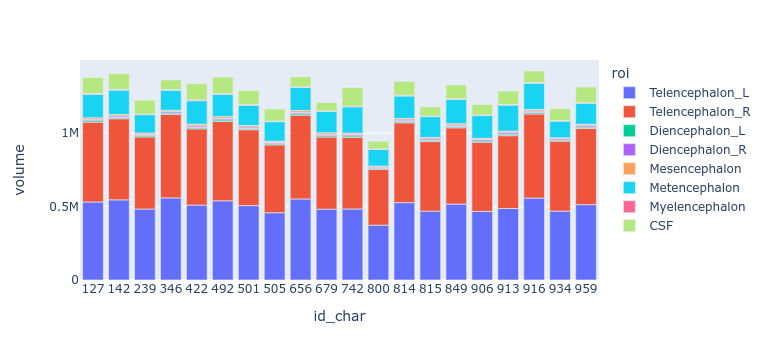

In [4]:
dat = dat.assign(id_char = dat.id.astype(str))
fig = px.bar(dat, x = "id_char", y = "volume", color = "roi")
fig.show()

Let's add an intra-cranial volume column by grouping by id, summing all volumes, then merging that data back into the main data. We'll then add a composition variable, which is the regional volumes divided by the intra-cranial volume.

In [4]:
icv = dat.groupby(['id']).volume.sum().reset_index().rename(columns = {'volume' : 'icv'})
dat = pd.merge(dat, icv, on = 'id')
dat = dat.assign(comp = dat.volume / dat.icv)
dat.head()

,id,roi,volume,id_char,icv,comp
0,127,Telencephalon_L,531111,127,1378295,0.385339
1,127,Telencephalon_R,543404,127,1378295,0.394258
2,127,Diencephalon_L,9683,127,1378295,0.007025
3,127,Diencephalon_R,9678,127,1378295,0.007022
4,127,Mesencephalon,10268,127,1378295,0.007450


Let's now replot our compositional data (but now normalized to have height 1).

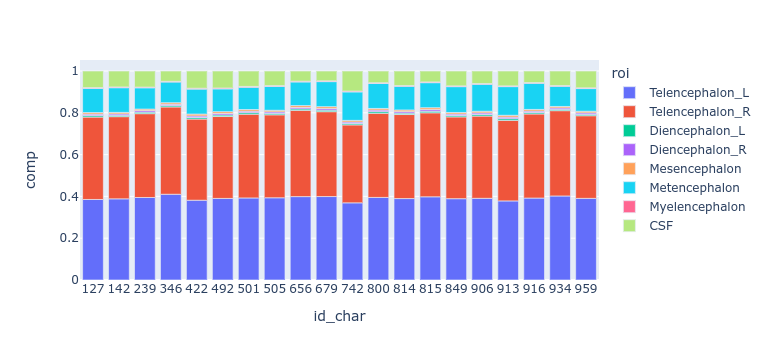

In [5]:
fig = px.bar(dat, x = "id_char", y = "comp", color = "roi")
fig.show()

Let's look at the subject level means. Therefore, we have to average across id.

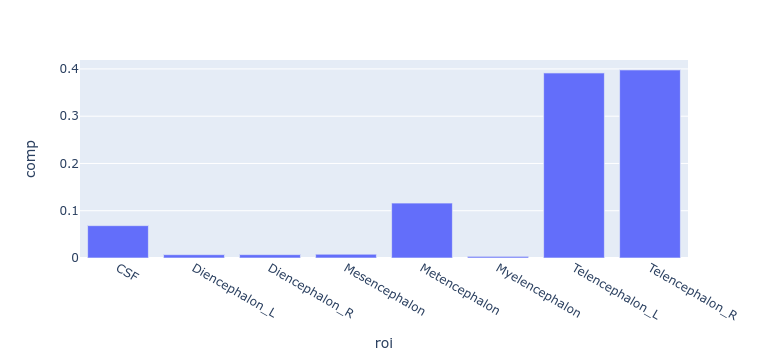

In [12]:
roi_mean = dat.drop(["id", "id_char", "icv"], axis = 1).groupby(["roi"]).mean().reset_index()
fig = px.bar(roi_mean, x = "roi", y = "comp")
fig.show()

There's a hierarchy of regions in this dataset. Let's visualize a subject's type 1 level 5 data as it exists in the hierarchy.

In [8]:
## load in the hierarchy information
url = "https://raw.githubusercontent.com/bcaffo/MRIcloudT1volumetrics/master/inst/extdata/multilevel_lookup_table.txt"
multilevel_lookup = pd.read_csv(url, sep = "\t").drop(['Level5'], axis = 1)
multilevel_lookup = multilevel_lookup.rename(columns = {
    "modify"   : "roi", 
    "modify.1" : "level4",
    "modify.2" : "level3", 
    "modify.3" : "level2",
    "modify.4" : "level1"})
multilevel_lookup = multilevel_lookup[['roi', 'level4', 'level3', 'level2', 'level1']]
multilevel_lookup.head()

,roi,level4,level3,level2,level1
0,SFG_L,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L
1,SFG_R,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R
2,SFG_PFC_L,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L
3,SFG_PFC_R,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R
4,SFG_pole_L,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L


In [10]:
## Now load in the subject data
id = 127
subjectData = pd.read_csv("assetts/kirby21AllLevels.csv")
subjectData = subjectData.loc[(subjectData.type == 1) & (subjectData.level == 5) & (subjectData.id == id)]
subjectData = subjectData[['roi', 'volume']]
## Merge the subject data with the multilevel data
subjectData = pd.merge(subjectData, multilevel_lookup, on = "roi")
subjectData = subjectData.assign(icv = "ICV")
subjectData = subjectData.assign(comp = subjectData.volume / np.sum(subjectData.volume))
subjectData.head()

,roi,volume,level4,level3,level2,level1,icv,comp
0,SFG_L,12926,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,ICV,0.009350
1,SFG_R,10050,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R,ICV,0.007270
2,SFG_PFC_L,12783,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,ICV,0.009247
3,SFG_PFC_R,11507,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R,ICV,0.008324
4,SFG_pole_L,3078,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,ICV,0.002227


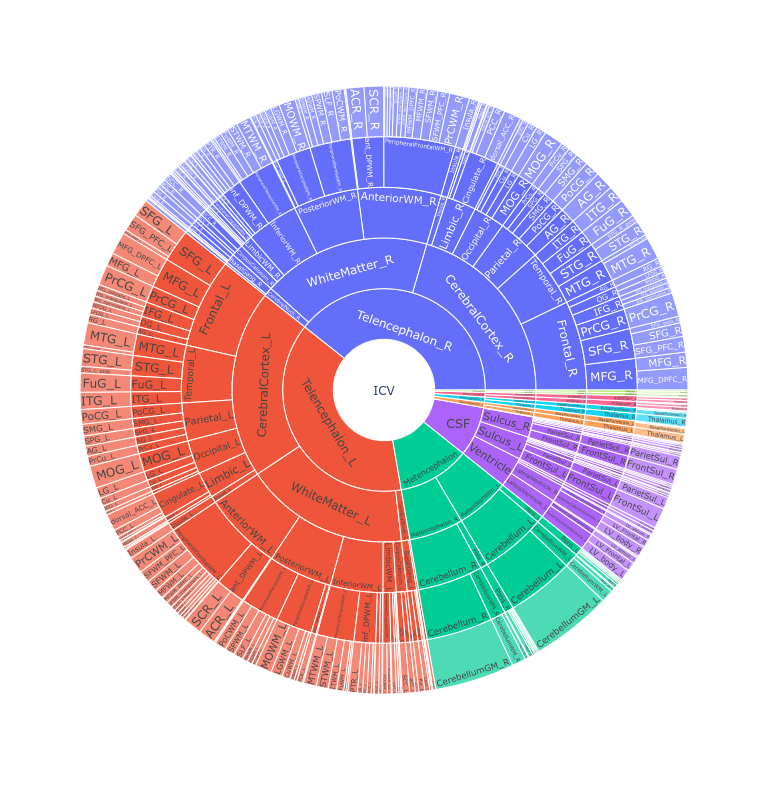

In [72]:
fig = px.sunburst(subjectData, path=['icv', 'level1', 'level2', 'level3', 'level4', 'roi'], 
                  values='comp', width=800, height=800)
fig.show()

Similarly, we can make a treemap.

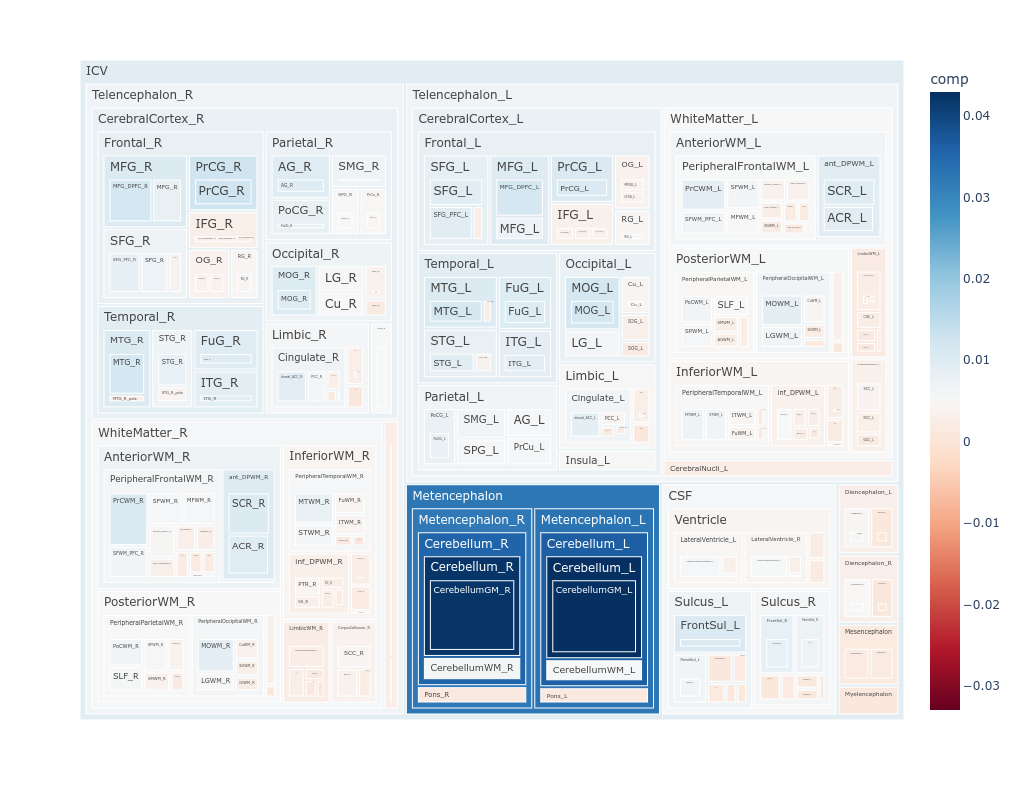

In [80]:
fig = px.treemap(subjectData, 
                 path = ['icv', 'level1', 'level2', 'level3', 'level4', 'roi'], 
                 values='comp',
                 color='comp', 
                 color_continuous_scale = 'RdBu',
                 color_continuous_midpoint = .005,
                 width=800, height=800
                )
fig.show()